In [1]:
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import scikitplot as skp

%matplotlib inline

sns.set_palette('pastel')

## Read the Data

In [2]:
# read the pickled data
pickle_data = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'clean_data.pickle'), 'rb')
data = pickle.load(pickle_data)
# rename the columns for plotting
data.columns = ['Year', 'Income Index', 'Education Index', 'Percent White',
                'Rent Index', 'Value Index', 'Percent Employed']
# reorder the columns so value index is first feature
data = data[['Year', 'Value Index', 'Income Index', 'Education Index', 
             'Percent White', 'Rent Index', 'Percent Employed']]
# first column is year, which I don't want to mess with
cols = data.columns[1:]

## Standardization

In [3]:
# create instance of RobustScaler class
rs = RobustScaler()
# fit and transform the data and put back into a dataframe
data_rs = pd.DataFrame(rs.fit_transform(data[cols]), index=data.index, columns=cols)

## Dimension Reduction (Plotting)

In [4]:
# create instance of PCA class
pca = PCA()
# fit and transform the data and put back into dataframe
data_pca = pd.DataFrame(pca.fit_transform(data_rs), index=data.index)
# rename the columns
data_pca.columns = ['pca{}'.format(i) for i in range(1, 7)]

## KMeans Clustering (6 clusters)

In [5]:
# create kmeans model
kmeans = KMeans(n_clusters=6, random_state=0)
# fit the model and predict the labels
labels = kmeans.fit_predict(data_rs)
# assign the clusters to a new column in the original dataset
data['clusters'] = labels
data.head()

,Year,Value Index,Income Index,Education Index,Percent White,Rent Index,Percent Employed,clusters
geoid,,,,,,,,
48021950100,2000,153375.729370,73599.981153,3.617289,86.192698,723.087018,98.308865,1
48021950200,2000,118748.232408,67668.904461,3.154098,67.591995,752.448335,96.715168,5
48021950300,2000,178808.676101,78678.935400,3.669384,81.097069,808.205215,97.032326,1
48021950400,2000,158917.899778,75438.539903,4.075207,76.605317,869.478211,98.340471,1
48021950600,2000,134719.422878,67172.153161,3.465056,88.921283,737.822784,96.891342,1


## Clustering Analysis

### Ordering the Clusters
I'll start by logically ordering the clusters by median home value from lowest to highest. The reason for this is that the numbering of kmeans cluster centers is random and changes from model run to model run. Ordering them logically will come in handy when seeing how the neighborhoods move between clusters.

In [6]:
# group by cluster -> get median home value for each cluster -> rank them (low to high)
# -> cast as integer -> convert to dict -> map new cluster numbers
clust_map = data.groupby('clusters')['Value Index'].median().rank().astype('int').to_dict()
# map the new cluster labels
data['clusters'] = data['clusters'].map(clust_map)
data.head()

,Year,Value Index,Income Index,Education Index,Percent White,Rent Index,Percent Employed,clusters
geoid,,,,,,,,
48021950100,2000,153375.729370,73599.981153,3.617289,86.192698,723.087018,98.308865,3
48021950200,2000,118748.232408,67668.904461,3.154098,67.591995,752.448335,96.715168,1
48021950300,2000,178808.676101,78678.935400,3.669384,81.097069,808.205215,97.032326,3
48021950400,2000,158917.899778,75438.539903,4.075207,76.605317,869.478211,98.340471,3
48021950600,2000,134719.422878,67172.153161,3.465056,88.921283,737.822784,96.891342,3


## Analyzing the Clusters

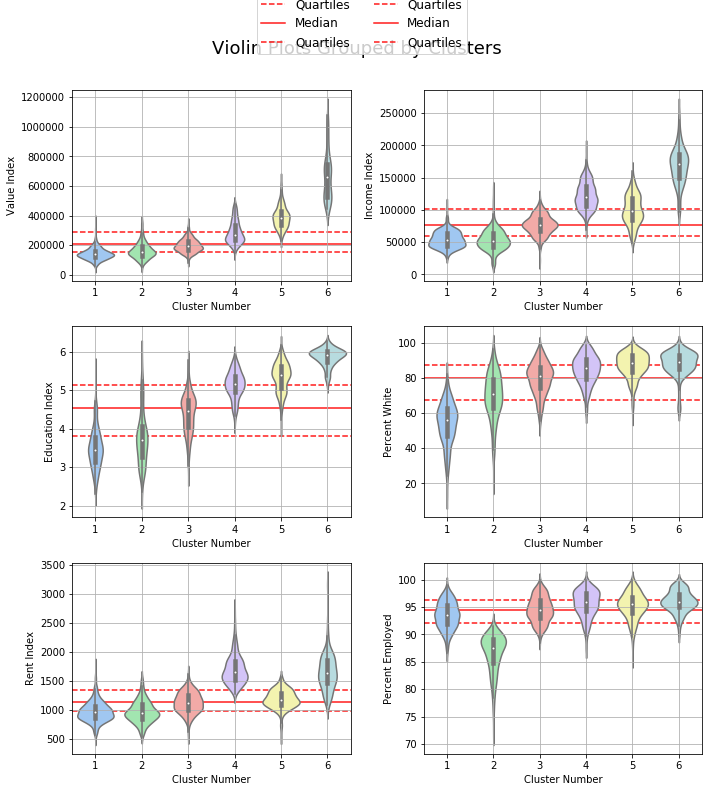

In [7]:
# create the figure and subplot axes
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
# loop through columns to make subplots
for col, ax in zip(cols, axes.flatten()):
    # plot the violins for each column
    _ = sns.violinplot(x='clusters', y=col, data=data, ax=ax)
    # create horizontal lines for median and 25th/75th quartiles
    _ = ax.axhline(data[col].median(), c='r', label='Median', alpha=0.9, zorder=0)
    _ = ax.axhline(data[col].quantile(0.25), c='r', linestyle='--', label='Quartiles', alpha=0.9, zorder=0)
    _ = ax.axhline(data[col].quantile(0.75), c='r', linestyle='--', alpha=0.9, zorder=0)
    # rename the xlabel
    _ = ax.set(xlabel='Cluster Number')
    # turn on the grid
    _ = ax.grid()

# create a super title for the figure
_ = fig.suptitle('Violin Plots Grouped by Clusters', y=1.05, fontsize=18)
_ = fig.tight_layout()
# create a single legend for the entire figure
_ = fig.legend(loc=(0.36, 0.932), ncol=2, fontsize=12)

_ = fig.savefig('../figures/violins.png', dpi=500, transparent=True, bbox_inches='tight')

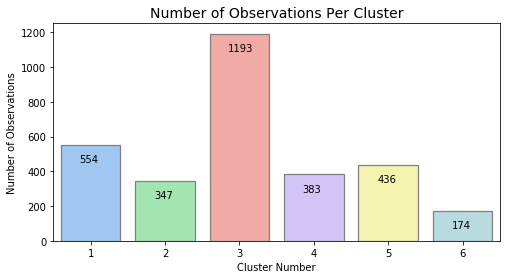

In [8]:
cluster_counts = data.groupby('clusters').count()['Year'].to_frame()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

g = sns.barplot(x='clusters', y='Year', data=cluster_counts.reset_index(), ax=ax, 
                linewidth=1.25, edgecolor=".5")

for i, r in cluster_counts.iterrows():
    g.text(r.name-1.15, r.Year-100, r.Year)

_ = ax.set_xlabel('Cluster Number', fontsize=10)
_ = ax.set_ylabel('Number of Observations', fontsize=10)
_ = ax.set_title('Number of Observations Per Cluster', fontsize=14)

_ = fig.savefig('../figures/obs_per_cluster.png', dpi=500, transparent=True)

## Analyzing Neighborhood Clustering

In [9]:
geoid_clusters = data.groupby('geoid')['clusters'].apply(list).to_frame()
geoid_clusters.head()

,clusters
geoid,
48021950100,"[3, 3, 3, 3, 3, 3, 3, 3, 3]"
48021950200,"[1, 1, 1, 1, 1, 2, 1, 1, 1]"
48021950300,"[3, 3, 3, 3, 3, 3, 2, 2, 3]"
48021950400,"[3, 3, 3, 3, 3, 2, 3, 3, 3]"
48021950501,"[3, 3, 1, 1, 1, 3, 2, 2, 2]"


In [10]:
def max_change(x):
    change = np.max(x) - np.min(x)
    if x.index(np.max(x)) < x.index(np.min(x)):
        change *= -1
        return change
    return change

In [11]:
#get the number of unique clusters for each geoid
geoid_clusters['num_unique'] = geoid_clusters['clusters'].apply(lambda x: len(np.unique(x)))
#get the change in clusters from 2000 to 2016
geoid_clusters['change_00_16'] = geoid_clusters['clusters'].apply(lambda x: x[-1] - x[0])
#get the change from lowest cluster number to highest cluster number
geoid_clusters['max_change'] = geoid_clusters['clusters'].apply(max_change)
geoid_clusters.head()

,clusters,num_unique,change_00_16,max_change
geoid,,,,
48021950100,"[3, 3, 3, 3, 3, 3, 3, 3, 3]",1,0,0
48021950200,"[1, 1, 1, 1, 1, 2, 1, 1, 1]",2,0,1
48021950300,"[3, 3, 3, 3, 3, 3, 2, 2, 3]",2,0,-1
48021950400,"[3, 3, 3, 3, 3, 2, 3, 3, 3]",2,0,-1
48021950501,"[3, 3, 1, 1, 1, 3, 2, 2, 2]",3,-1,-2


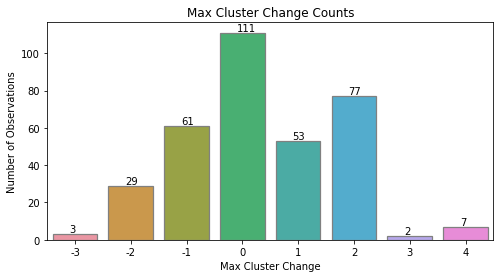

In [12]:
max_change = geoid_clusters.groupby('max_change')['clusters'].count().to_frame()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

g = sns.barplot(x='max_change', y='clusters', data=max_change.reset_index(),
                linewidth=1.25, edgecolor=".5", ax=ax)

for i, r in max_change.iterrows():
    g.text(r.name+2.9, r.clusters+1, r.clusters)

_ = ax.set_xlabel('Max Cluster Change')
_ = ax.set_ylabel('Number of Observations')
_ = ax.set_title('Max Cluster Change Counts')

_ = fig.savefig('../figures/max_change.png', dpi=500, transparent=True)

In [13]:
display(geoid_clusters[geoid_clusters['max_change'] == -3][['clusters', 'max_change']])
display(geoid_clusters[geoid_clusters['max_change'] == 3][['clusters', 'max_change']])
display(geoid_clusters[geoid_clusters['max_change'] == 4][['clusters', 'max_change']])

,clusters,max_change
geoid,,
48453001745,"[4, 5, 2, 3, 3, 3, 4, 4, 5]",-3
48453001854,"[3, 4, 3, 1, 1, 1, 1, 1, 1]",-3
48491020315,"[4, 3, 5, 2, 2, 2, 2, 5, 4]",-3


,clusters,max_change
geoid,,
48453000901,"[1, 2, 2, 2, 2, 2, 3, 3, 4]",3
48453001100,"[3, 4, 4, 4, 4, 6, 6, 6, 6]",3


,clusters,max_change
geoid,,
48453000306,"[1, 3, 3, 5, 5, 5, 5, 5, 5]",4
48453000307,"[1, 3, 5, 5, 5, 5, 5, 5, 5]",4
48453000803,"[1, 1, 1, 1, 3, 3, 3, 5, 3]",4
48453001305,"[1, 3, 5, 5, 5, 5, 5, 5, 5]",4
48453001307,"[1, 1, 2, 3, 3, 3, 3, 3, 5]",4
48453001308,"[1, 3, 3, 3, 3, 3, 3, 3, 5]",4
48453002005,"[1, 1, 3, 3, 3, 3, 3, 3, 5]",4


## Bokeh Clusters

In [41]:
# import standard libraries
import pandas as pd
import numpy as np
import os
import pickle
# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import mapping libraries
from cartopy.io.shapereader import Reader
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, ColorMapper, ColorBar
from bokeh.io import output_notebook, show, save
from bokeh.plotting import figure
#from bokeh.palettes import RdBu11 as palette
from bokeh.palettes import RdYlGn11 as palette
from bokeh.models.widgets import Panel, Tabs
from bokeh.resources import CDN
# import HTML to show the bokeh plot
from IPython.display import HTML
# make the plots inline
%matplotlib inline
# activate bokeh javascript output
output_notebook()

palette.reverse()

Loading BokehJS ...

In [42]:
def make_source(year):
    source = ColumnDataSource(data=dict(
        x=xs,
        y=ys,
        name=names,
        tract=tract,
        cluster=data[data['Year'] == year].loc[names, 'clusters'],
        year=data[data['Year'] == year].loc[names, 'Year']
    ))
    return source

def make_tab(year):
    p = figure(title='Clusters in {}'.format(year), tools=TOOLS,
               x_axis_location=None, y_axis_location=None)
    r = p.patches('x', 'y', source=make_source(year),
                  fill_color={'field': 'cluster', 'transform': color_mapper},
                  fill_alpha=0.8, line_color='black', line_width=0.5)
    h = p.select_one(HoverTool)
    h.point_policy = 'follow_mouse'
    h.tooltips = [
        ('Year', '@year'),
        ('GeoID', '@name'),
        ('Census Tract', '@tract'),
        ('Lon, Lat', '$x, $y'),
        ('Cluster', '@cluster')
    ]
    tab = Panel(child=p, title=year)
    return tab

In [65]:
geoids = list(set(data.index))

tracts = Reader(os.path.join('..', 'shapefiles', 'austin_metro_tracts.shp'))

xs, ys, names, tract = [], [], [], []
for r, g in zip(tracts.records(), tracts.geometries()):
    if int(r.attributes['GEOID']) in geoids:
        xs.append(list(g[0].exterior.coords.xy[0]))
        ys.append(list(g[0].exterior.coords.xy[1]))
        names.append(int(r.attributes['GEOID']))
        tract.append(float(r.attributes['GEOID'][-6:]) / 100)

color_mapper = LinearColorMapper(palette=palette)

TOOLS = 'pan, wheel_zoom, hover, reset, save'

years = ['2000', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']

tabs = [make_tab(year) for year in years]

T = Tabs(tabs=tabs)

_ = save(T, filename=os.path.join('..', 'figures', 'clusters_by_year.html'),
         title='Clusters by Year', resources=CDN)